# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TRAINING

Mounted at /content/drive
/content/drive/MyDrive/TRAINING


In [ ]:
%%capture
!pip install sentence_transformers pypdf

In [2]:
from sklearn.neighbors import LocalOutlierFactor

In [3]:
from sentence_transformers import SentenceTransformer, InputExample,evaluation,models, losses, util
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import numpy as np
import json
import pandas as pd
import nltk
nltk.download('punkt')
from collections import Counter
import random
random.seed(42)
from helpers import *
import os
from datetime import datetime
import torch
from pypdf import PdfReader

c:\Users\lw\miniconda3\envs\masterarbeit_lwo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# helpers 

In [ ]:
def community_detection(embeddings, threshold=0.75, min_community_size=10, batch_size=1024):
    """
    Function for Fast Community Detection
    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    threshold = torch.tensor(threshold, device=embeddings.device)

    extracted_communities = []

    # Maximum size for community
    min_community_size = min(min_community_size, len(embeddings))
    sort_max_size = min(max(2 * min_community_size, 50), len(embeddings))

    for start_idx in range(0, len(embeddings), batch_size):
        # Compute cosine similarity scores
        cos_scores = util.cos_sim(embeddings[start_idx:start_idx + batch_size], embeddings)
        # Minimum size for a community
        top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

        # Filter for rows >= min_threshold
        for i in range(len(top_k_values)):
            if top_k_values[i][-1] >= threshold:
                new_cluster = []

                # Only check top k most similar entries
                top_val_large, top_idx_large = cos_scores[i].topk(k=sort_max_size, largest=True)

                # Check if we need to increase sort_max_size
                while top_val_large[-1] > threshold and sort_max_size < len(embeddings):
                    sort_max_size = min(2 * sort_max_size, len(embeddings))
                    top_val_large, top_idx_large = cos_scores[i].topk(k=sort_max_size, largest=True)

                for idx, val in zip(top_idx_large.tolist(), top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)

                extracted_communities.append(new_cluster)

        del cos_scores

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for cluster_id, community in enumerate(extracted_communities):
        community = sorted(community)
        non_overlapped_community = []
        for idx in community:
            if idx not in extracted_ids:
                non_overlapped_community.append(idx)

        if len(non_overlapped_community) >= min_community_size:
            unique_communities.append(non_overlapped_community)
            extracted_ids.update(non_overlapped_community)

    unique_communities = sorted(unique_communities, key=lambda x: len(x), reverse=True)

    return unique_communities

In [ ]:
def filter_communities_total(df,columnname_to_encode, model, min_community_size=10, threshold=0.75):

    unique_texts = list(set(df[columnname_to_encode]))
    print(f"{len(unique_texts)} ads to encode.")
    embedding_map = {}
    embeddings = model.encode(unique_texts,show_progress_bar=True,convert_to_tensor=True, batch_size=64)
    print("Finished encoding.")
    for text, embedding in zip(unique_texts,embeddings.tolist()):
      embedding_map[text] = embedding
    df["embeddings"] = df[columnname_to_encode].map(embedding_map)

    results = []
    esco_ids = list(df["esco_id"].unique())
    df["community"] = None
    print("Adding Communities.")
    for id in tqdm((esco_ids)):
        filtered_df = df[df["esco_id"]==id].reset_index(drop=True)
        #display(filtered_df)
        if len(filtered_df) < min_community_size:
            filtered_df["community"] = 0
        else:
            embds = [torch.FloatTensor(x) for x in filtered_df["embeddings"]]
            embds = torch.stack(embds)
            communities = community_detection(embds,threshold=threshold,min_community_size=min_community_size)
            if len(communities) > 0:
              for index, community in enumerate(communities):
                filtered_df.loc[community, "community"] = index
            else:
              filtered_df["community"] = 0
        results += filtered_df.to_dict("records")
    result_df = pd.DataFrame(results)
    result_df.reset_index(drop=True,inplace=True)
    return result_df

In [ ]:
def create_embedding_df(df,columnname_to_encode, model):

    unique_texts = list(set(df[columnname_to_encode]))
    print(f"{len(unique_texts)} ads to encode.")
    embedding_map = {}
    embeddings = model.encode(unique_texts,show_progress_bar=True,convert_to_tensor=True, batch_size=64)
    print("Finished encoding.")
    for text, embedding in zip(unique_texts,embeddings.tolist()):
      embedding_map[text] = embedding
    df["embeddings"] = df[columnname_to_encode].map(embedding_map)

    return df

# Load Data

In [ ]:
jobs = (load_json(r"../00_data/ESCO/ESCO_JOBS_ALL.json"))
esco_lookup = {}
for job in jobs:
  esco_lookup[job["jobid_esco"]] = job["jobtitle"]


# Model Loading

In [ ]:
# for model in os.listdir('/content/drive/MyDrive/TRAINING/_COSINESIM/content/'):
#   print(f"Available model: {model}")

In [4]:
model_path = "../00_data/SBERT_Models/models/jobgbert_batch32_woTSDAE_2e-05_f10/"
model = SentenceTransformer(f"{model_path}") 
embeddings = load_pickle(f"{model_path}embeddings.pkl")

In [11]:
# df_new = create_embedding_df(ads_df,"short+title", model)
#write_pickle(f"{model_path}_embdads_wEmbd.pkl", df_new)

In [12]:
df_new = load_pickle(f"{model_path}_embdads_wEmbd.pkl")
embds = [torch.FloatTensor(x) for x in tqdm(df_new["embeddings"])]
embds = torch.stack(embds)

100%|██████████| 152071/152071 [00:12<00:00, 12293.71it/s]


In [13]:
uniqueids = list(set(df_new["esco_id"].unique()))
unfiltered_centroids = {}
for id in tqdm(uniqueids):
  id_filter = df_new[df_new["esco_id"]==id]
  unfiltered_centroids[id] = np.stack(list(id_filter["embeddings"])).mean(axis=0, dtype="float32")

100%|██████████| 1700/1700 [00:26<00:00, 64.44it/s]


In [14]:
def load_cvs():
    cvs = []
    for i in range(1,6):
        cv = ""
        reader = PdfReader(f"../00_data/CVs/CV_{i}.pdf")

        pages = reader.pages
        for i in range(len(pages)):
            page = reader.pages[i].extract_text().strip()
            cv +=page
        cvs.append(cv)
    return cvs

In [15]:
cvs = load_cvs()

In [16]:
# input_encoded = model.encode(cvs[1])
# similarities = util.semantic_search(input_encoded,embds, top_k=20)
# print(similarities)
# simids = [x["corpus_id"] for x in similarities[0]]
# df_new.iloc[simids].iloc[2]["short_texts"]

# LOF 

In [17]:
def create_filtered_centroids_lof(n_neighbors):
  res_lof = []

  for id in tqdm(uniqueids):
    id_filter = df_new[df_new["esco_id"]==id].copy()
    #print(len(id_filter))
    if len(id_filter) < n_neighbors:
      id_filter["outliers"] = 1
    else:
      clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
      id_filter["outliers"] = clf.fit_predict(list(id_filter["embeddings"]))
    res_lof.append(id_filter)
  res_lof_df = pd.concat(res_lof).reset_index(drop=True)

  res_lof_df_filtered = res_lof_df[res_lof_df["outliers"]==1]

  filtered_centroids_lof = {}
  for id in tqdm(uniqueids):
    id_filter = res_lof_df_filtered[res_lof_df_filtered["esco_id"]==id]
    filtered_centroids_lof[id] = np.stack(list(id_filter["embeddings"])).mean(axis=0, dtype="float32")
  return filtered_centroids_lof

In [ ]:
n_neighbors = 200
filtered_centroids_lof = create_filtered_centroids_lof(n_neighbors)

# Community Detection

In [19]:
def create_filtered_centroids_comm(min_community_size,threshold):
  results = []
  for id in tqdm((uniqueids)):
    filtered_df = df_new[df_new["esco_id"]==id].reset_index(drop=True)
    #display(filtered_df)
    if len(filtered_df) < min_community_size:
        filtered_df["community"] = 0
    else:
        embds = [torch.FloatTensor(x) for x in filtered_df["embeddings"]]
        embds = torch.stack(embds)
        communities = community_detection(embds,threshold=threshold,min_community_size=min_community_size)
        if len(communities) > 0:
          for index, community in enumerate(communities):
            filtered_df.loc[community, "community"] = index
        else:
          filtered_df["community"] = 0
    results += filtered_df.to_dict("records")
  res_comm_df = pd.DataFrame(results)

  res_comm_df_filtered = res_comm_df[res_comm_df["community"]==0]

  filtered_centroids_community = {}
  for id in tqdm(uniqueids):
    id_filter = res_comm_df_filtered[res_comm_df_filtered["esco_id"]==id]
    filtered_centroids_community[id] = np.stack(list(id_filter["embeddings"])).mean(axis=0, dtype="float32")
  
  return filtered_centroids_community

In [20]:
min_community_size = 100
threshold = 0.5

filtered_centroids_community = create_filtered_centroids_comm(min_community_size,threshold)

100%|██████████| 1700/1700 [00:21<00:00, 77.40it/s]


In [ ]:
filtered_centroids_community.keys()

# Testing

In [21]:
testads = load_pickle(f"{model_path}_testads_wEmbd.pkl")
testads.columns

Index(['searched_esco_job', 'title', 'url', 'esco_jobs', 'publication_date',
       'esco_job', 'esco_id', 'no_esco_jobs', 'parsed_title', 'ESCOJOB',
       'description', 'short_texts', 'embeddings_short'],
      dtype='object')

In [22]:
testads = pd.DataFrame(load_json(r"/content/drive/MyDrive/TRAINING/data/eures_testads_final_short.json"))
encodings_short = model.encode(list(testads["short_texts"]), show_progress_bar=True)
testads["embeddings_short"] = encodings_short.tolist()
# write_pickle(f"{model_path}_testads_wEmbd.pkl", testads)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
# encodings_short = model.encode(list(testads["short_texts"]), show_progress_bar=True)
# encodings_long = model.encode(list(testads["short_texts"]), show_progress_bar=True)


In [ ]:
# MRR = []
# MRR_AT = 100
# currently = "".join([c for c in str(datetime.now()).split('.')[0] if c.isdigit()])

# embeddings={}

# embeddings["centroid_unfiltered"] = {"esco_id":list(unfiltered_centroids.keys()), "embeddings": list(unfiltered_centroids.values())}
# embeddings["centroid_filtered_comm"] = {"esco_id":list(filtered_centroids_community.keys()), "embeddings": list(filtered_centroids_community.values())}
# embeddings["centroid_filtered_lof"] = {"esco_id":list(filtered_centroids_lof.keys()), "embeddings": list(filtered_centroids_lof.values())}


# print(embeddings.keys())
# # #encodings_long = model.encode(list(testads["description"]), show_progress_bar=True) 
# #testads["embeddings_long"] = encodings_long.tolist()

# for textkind in ["embeddings_short"]:
#   similarities = {}
#   for k in embeddings:
#     similarities[k] = (util.cos_sim(testads[textkind],embeddings[k]["embeddings"]))
  
#   for k in similarities:
#     ranks = []
#     missing = 0
#     simdf = pd.DataFrame(similarities[k],columns=embeddings[k]["esco_id"], index=testads["esco_id"])
#     for i in tqdm(range(len(simdf))):
#       id = simdf.iloc[i].name
#       series = simdf.iloc[i].sort_values(ascending=False).reset_index()
#       #print(series)
#       rank = (series[series["index"]==id].index.item()+1)
#       #print(rank)
#       if rank > MRR_AT:
#         missing +=1
#         ranks.append(0)
#       else:
#         ranks.append(1/rank)
#     missing = missing/len(simdf)
#     MRR.append({"model":model_path.split("/")[-2],"textkind": textkind,"embedding_kind":k, "MRR":np.mean(ranks), "missing":missing, "MRR@":MRR_AT})
#     df = pd.DataFrame(MRR).sort_values(by=["MRR"], ascending=[False]).reset_index(drop=True)
#     display(df)
#     #df.to_excel(f"/content/drive/MyDrive/TRAINING/_COSINESIM/{currently}_evaluation.xlsx")

In [23]:
def make_evaluation(embeddings, n_neighbor,min_com_size,threshold):
  MRR = []
  MRR_AT = 100
  # currently = "".join([c for c in str(datetime.now()).split('.')[0] if c.isdigit()])

  # #encodings_long = model.encode(list(testads["description"]), show_progress_bar=True) 
  #testads["embeddings_long"] = encodings_long.tolist()

  for textkind in ["embeddings_short"]:
    similarities = {}
    for k in embeddings:
      similarities[k] = (util.cos_sim(testads[textkind],embeddings[k]["embeddings"]))
    
    for k in similarities:
      ranks = []
      missing = 0
      simdf = pd.DataFrame(similarities[k],columns=embeddings[k]["esco_id"], index=testads["esco_id"])
      for i in tqdm(range(len(simdf))):
        id = simdf.iloc[i].name
        series = simdf.iloc[i].sort_values(ascending=False).reset_index()
        #print(series)
        rank = (series[series["index"]==id].index.item()+1)
        #print(rank)
        if rank > MRR_AT:
          missing +=1
          ranks.append(0)
        else:
          ranks.append(1/rank)
      missing = missing/len(simdf)
      MRR.append({"model":model_path.split("/")[-2],
                  "n_neighbor":n_neighbor,"min_com_size":min_com_size,
                  "threshold": threshold,"embedding_kind":k, "MRR":np.mean(ranks), 
                  "missing":missing, "MRR@":MRR_AT})
      df = pd.DataFrame(MRR).sort_values(by=["MRR"], ascending=[False]).reset_index(drop=True)
      #df.to_excel(f"/content/drive/MyDrive/TRAINING/_COSINESIM/{currently}_evaluation.xlsx")
  return df

In [24]:
embeddings_unfiltered = {"unfiltered": {"esco_id":list(unfiltered_centroids.keys()), "embeddings": list(unfiltered_centroids.values())}}
benchmark_unfiltered = make_evaluation(embeddings_unfiltered,None,None,None)
benchmark_unfiltered

/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  b = torch.tensor(b)
100%|██████████| 2250/2250 [00:03<00:00, 725.12it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,None,None,None,unfiltered,0.481551,0.08,100


## LOF

In [ ]:
results_lof = []
for n_neighbor in [500,400,300,200,100,50,10]:
  embeddings = {}
  print(f"Creating Embeddings for n_neighbors {n_neighbor}")
  filtered_centroids_lof = create_filtered_centroids_lof(n_neighbor)
  embeddings["centroid_filtered_lof"] = {"esco_id":list(filtered_centroids_lof.keys()), "embeddings": list(filtered_centroids_lof.values())}
  print("Evaluating")
  results_lof.append(make_evaluation(embeddings, n_neighbor,None,None))
  display(pd.concat(results_lof).reset_index(drop=True))
eval_lof_results = pd.concat(results_lof).reset_index(drop=True)

Creating Embeddings for n_neighbors 500


100%|██████████| 1700/1700 [00:23<00:00, 73.14it/s]


Evaluating


100%|██████████| 2250/2250 [00:04<00:00, 531.20it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.08,100


Creating Embeddings for n_neighbors 400


100%|██████████| 1700/1700 [00:24<00:00, 68.99it/s]


Evaluating


100%|██████████| 2250/2250 [00:03<00:00, 609.53it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.08,100
1,jobgbert_batch32_woTSDAE_2e-05_f10,400,None,None,centroid_filtered_lof,0.482434,0.08,100


Creating Embeddings for n_neighbors 300


100%|██████████| 1700/1700 [00:24<00:00, 69.76it/s]


Evaluating


100%|██████████| 2250/2250 [00:03<00:00, 630.49it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.08,100
1,jobgbert_batch32_woTSDAE_2e-05_f10,400,None,None,centroid_filtered_lof,0.482434,0.08,100
2,jobgbert_batch32_woTSDAE_2e-05_f10,300,None,None,centroid_filtered_lof,0.483375,0.08,100


Creating Embeddings for n_neighbors 200


100%|██████████| 1700/1700 [00:24<00:00, 69.42it/s]


Evaluating


100%|██████████| 2250/2250 [00:03<00:00, 615.53it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.080000,100
1,jobgbert_batch32_woTSDAE_2e-05_f10,400,None,None,centroid_filtered_lof,0.482434,0.080000,100
2,jobgbert_batch32_woTSDAE_2e-05_f10,300,None,None,centroid_filtered_lof,0.483375,0.080000,100
3,jobgbert_batch32_woTSDAE_2e-05_f10,200,None,None,centroid_filtered_lof,0.483947,0.081333,100


Creating Embeddings for n_neighbors 100


100%|██████████| 1700/1700 [00:23<00:00, 72.25it/s]


Evaluating


100%|██████████| 2250/2250 [00:03<00:00, 613.63it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.080000,100
1,jobgbert_batch32_woTSDAE_2e-05_f10,400,None,None,centroid_filtered_lof,0.482434,0.080000,100
2,jobgbert_batch32_woTSDAE_2e-05_f10,300,None,None,centroid_filtered_lof,0.483375,0.080000,100
3,jobgbert_batch32_woTSDAE_2e-05_f10,200,None,None,centroid_filtered_lof,0.483947,0.081333,100
4,jobgbert_batch32_woTSDAE_2e-05_f10,100,None,None,centroid_filtered_lof,0.483359,0.084444,100


Creating Embeddings for n_neighbors 50


100%|██████████| 1700/1700 [00:20<00:00, 81.12it/s]


Evaluating


100%|██████████| 2250/2250 [00:04<00:00, 517.19it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.080000,100
1,jobgbert_batch32_woTSDAE_2e-05_f10,400,None,None,centroid_filtered_lof,0.482434,0.080000,100
2,jobgbert_batch32_woTSDAE_2e-05_f10,300,None,None,centroid_filtered_lof,0.483375,0.080000,100
3,jobgbert_batch32_woTSDAE_2e-05_f10,200,None,None,centroid_filtered_lof,0.483947,0.081333,100
4,jobgbert_batch32_woTSDAE_2e-05_f10,100,None,None,centroid_filtered_lof,0.483359,0.084444,100
5,jobgbert_batch32_woTSDAE_2e-05_f10,50,None,None,centroid_filtered_lof,0.483437,0.084000,100


Creating Embeddings for n_neighbors 10


100%|██████████| 1700/1700 [00:22<00:00, 74.68it/s]


Evaluating


100%|██████████| 2250/2250 [00:03<00:00, 613.93it/s]


,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@
0,jobgbert_batch32_woTSDAE_2e-05_f10,500,None,None,centroid_filtered_lof,0.482582,0.080000,100
1,jobgbert_batch32_woTSDAE_2e-05_f10,400,None,None,centroid_filtered_lof,0.482434,0.080000,100
2,jobgbert_batch32_woTSDAE_2e-05_f10,300,None,None,centroid_filtered_lof,0.483375,0.080000,100
3,jobgbert_batch32_woTSDAE_2e-05_f10,200,None,None,centroid_filtered_lof,0.483947,0.081333,100
4,jobgbert_batch32_woTSDAE_2e-05_f10,100,None,None,centroid_filtered_lof,0.483359,0.084444,100
5,jobgbert_batch32_woTSDAE_2e-05_f10,50,None,None,centroid_filtered_lof,0.483437,0.084000,100
6,jobgbert_batch32_woTSDAE_2e-05_f10,10,None,None,centroid_filtered_lof,0.480336,0.083111,100


<Axes: xlabel='n_neighbor'>

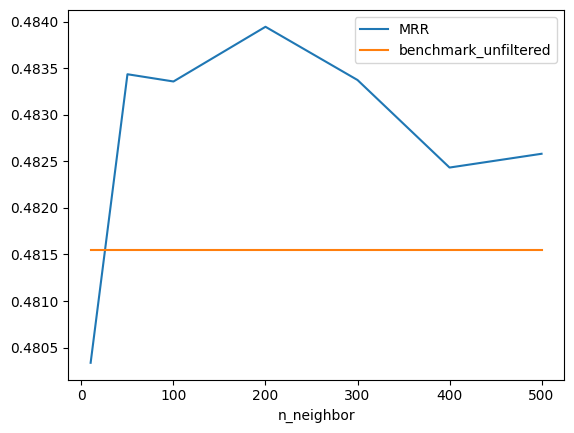

In [ ]:
eval_lof_results["benchmark_unfiltered"] = benchmark_unfiltered["MRR"].item()
eval_lof_results.plot(y=["MRR","benchmark_unfiltered"],x="n_neighbor")

In [ ]:
eval_lof_results.to_excel("/content/drive/MyDrive/TRAINING/_COSINESIM/eval_ads_outlier/results_lof_detect.xlsx")

## Comm

In [ ]:
results_comm = []
for min_com_size in [300,200,150,100,50,10]:
  for threshold in [0.9,0.8,0.75,0.5]:
    embeddings = {}
    print(f"Creating Embeddings for min_com_size {min_com_size} & treshold {threshold}")
    filtered_centroids_comm = create_filtered_centroids_comm(min_com_size, threshold)
    embeddings["centroid_filtered_comm"] = {"esco_id":list(filtered_centroids_comm.keys()), "embeddings": list(filtered_centroids_comm.values())}
    print("Evaluating")
    results_comm.append(make_evaluation(embeddings, None,min_com_size,threshold))
    display(pd.concat(results_comm).reset_index(drop=True))
eval_com_results = pd.concat(results_comm).reset_index(drop=True)

In [ ]:
eval_com_results["benchmark_unfiltered"] = benchmark_unfiltered["MRR"].item()

In [ ]:
eval_com_results.sort_values(by="MRR",ascending=False).head(3)

,model,n_neighbor,min_com_size,threshold,embedding_kind,MRR,missing,MRR@,benchmark_unfiltered
15,jobgbert_batch32_woTSDAE_2e-05_f10,None,100,0.5,centroid_filtered_comm,0.484125,0.083111,100,0.481551
5,jobgbert_batch32_woTSDAE_2e-05_f10,None,200,0.8,centroid_filtered_comm,0.484100,0.081778,100,0.481551
11,jobgbert_batch32_woTSDAE_2e-05_f10,None,150,0.5,centroid_filtered_comm,0.483863,0.080889,100,0.481551


<Axes: xlabel='min_com_size,threshold'>

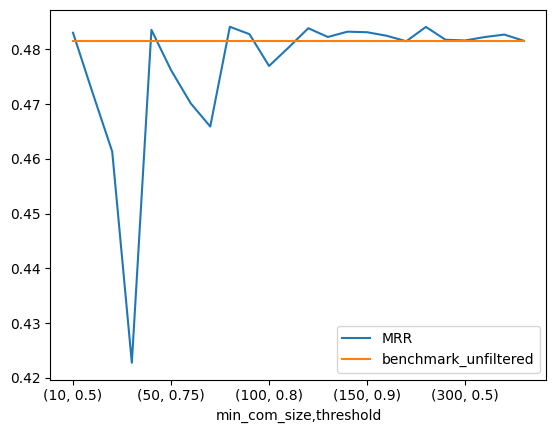

In [ ]:
eval_com_results.groupby(["min_com_size","threshold"]).max().plot(y=["MRR","benchmark_unfiltered"])

<Axes: xlabel='threshold'>

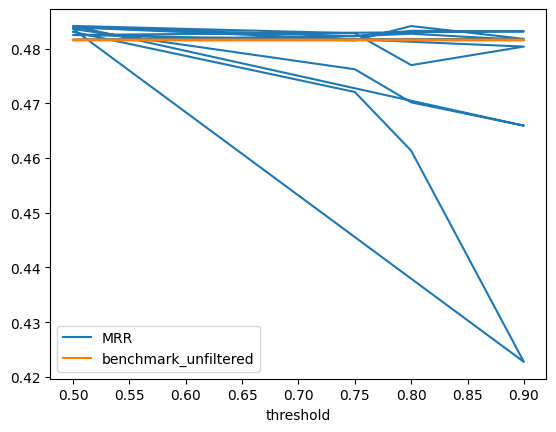

In [ ]:
eval_com_results.plot(y=["MRR","benchmark_unfiltered"],x="threshold")

In [ ]:
min_community_size = 100
threshold = 0.5

In [26]:
results = []
for id in tqdm((uniqueids)):
  filtered_df = df_new[df_new["esco_id"]==id].reset_index(drop=True)
  #display(filtered_df)
  if len(filtered_df) < min_community_size:
      filtered_df["community"] = 0
  else:
      embds = [torch.FloatTensor(x) for x in filtered_df["embeddings"]]
      embds = torch.stack(embds)
      communities = community_detection(embds,threshold=threshold,min_community_size=min_community_size)
      if len(communities) > 0:
        for index, community in enumerate(communities):
          filtered_df.loc[community, "community"] = index
      else:
        filtered_df["community"] = 0
  results += filtered_df.to_dict("records")
res_comm_df = pd.DataFrame(results)

res_comm_df_filtered = res_comm_df[res_comm_df["community"]==0]

filtered_centroids_community = {}

for id in tqdm(uniqueids):
  id_filter = res_comm_df_filtered[res_comm_df_filtered["esco_id"]==id]
  filtered_centroids_community[id] = np.stack(list(id_filter["embeddings"])).mean(axis=0, dtype="float32")

100%|██████████| 1700/1700 [00:23<00:00, 71.29it/s]
